In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import errno
import utils

import CGDs
import importlib
importlib.reload(CGDs)


from pyDOE import lhs
from torch import from_numpy

import torch
import torch.cuda
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad

# Manage device

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


In [3]:
# utils.printMemory()

# Data Sampling

In [4]:
samples = {"pde": 50000, "bc":25000, "fc":25000}

K = 40.0
r = 0.05
sigma = 0.25
T = 1.0
S_range = [0.0, 130.0]
t_range = [0.0, T]
gs = lambda x: np.fmax(x-K, 0.0)

# Build Neural Network

In [5]:
import networks
# Create the model
PINNCGD = networks.FeedforwardNeuralNetwork(2, 50, 1, 5)
PINNCGD.to(device)
print(PINNCGD)

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-4): 4 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


In [6]:
D_CGD = networks.Discriminator(2, 25, 2)
D_CGD.to(device)
D_CGD.load_state_dict(D_CGD.state_dict()) # copy weights and stuff
print(D_CGD)

Discriminator(
  (map): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=2, bias=True)
  )
)


# Network Trainig

### Hyperparameters

In [7]:
max_iter = 30000

tol = 1e-7
atol = 1e-20
g_iter = 1000
lr = 0.0002
track_cond = lambda x, y: True


# Define loss function and optimizer
# optimizer = CGDs.BCGD(max_params=D_CGD.parameters(), min_params=PINNCGD.parameters(), device = device,
#                  lr_max=lr, lr_min=lr, tol=1e-10, collect_info=True)
# optimizer = CGDs.ACGD(max_params=D_CGD.parameters(), min_params=PINNCGD.parameters(),
#                  lr_max=lr, lr_min=lr, tol=1e-10, beta=0.99, eps=1e-8, collect_info=True)
optimizer = CGDs.GACGD(x_params=D_CGD.parameters(), y_params = PINNCGD.parameters(), max_iter = g_iter,
            lr_x=lr, lr_y=lr, tol=tol, atol = atol, eps=1e-8, beta=0.99, track_cond = track_cond)
lossFunction = nn.MSELoss()
lossfunction2 = nn.L1Loss()

### Training

In [8]:
start_time=time.time()
loss_hist = []

for epoch in range(max_iter):
    
    optimizer.zero_grad() # zeroes the gradient buffers of all parameters
    
    # sampling
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, 
                       r, 
                       sigma, 
                       T, 
                       S_range[-1], 
                       S_range, 
                       t_range, 
                       gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)
    
    
    # normal loss
    # print(n_st_train)
    # print(PINNBCGD.output.weight.dtype)
    v1_hat = PINNCGD(n_st_train)
    
    grads = tgrad.grad(v1_hat, n_st_train, grad_outputs=torch.ones(v1_hat.shape).cuda(), 
                       retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(),
                          create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = n_st_train[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*v1_hat)
    
    loss1 = D_CGD(n_st_train)[:, [0]] * torch.abs(dVdt + 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*v1_hat)
    
    
    # boundary condition loss
    bc_hat = PINNCGD(bc_st_train)
    # print(bc_v_train)
    # print('111111111111111111111')
    # print(bc_hat)
    bc_loss = lossFunction(bc_v_train, bc_hat)
    
    loss2 = D_CGD(bc_st_train)[:, [1]] * torch.abs(bc_hat - bc_v_train)
    
    
    # Backpropagation and Update
    combined_loss = (loss1.mean() + loss2.mean())
    pinn_loss = pde_loss.mean() + bc_loss.mean()
    # combined_loss.backward()
    optimizer.step(-combined_loss, combined_loss, 0)
    # optimizer.step(combined_loss)
    
    loss_hist.append(pinn_loss.item())
    if epoch % 50 == 0:
        print(f'''{epoch}/{max_iter} mse loss: {pinn_loss.item():5f}, 
              PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, nn loss: {combined_loss.item():5f}''')
        pass
        
end_time = time.time()
print('run time:', end_time - start_time)
print('finish')

c:\Users\hengr\miniconda3\envs\honor\lib\site-packages\CGDs\gmres_torch.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2197.)
  y, _ = torch.triangular_solve(beta[0:j + 1].unsqueeze(-1), H[0:j + 1, 0:j + 1])  # j x j


0/30000 mse loss: 3360.023682, 
              PDE Loss: 0.00009, BC Loss: 3360.02368, nn loss: -53.276093
50/30000 mse loss: 1447.681274, 
              PDE Loss: 0.01621, BC Loss: 1447.66504, nn loss: 344.412933
100/30000 mse loss: 85.532639, 
              PDE Loss: 0.11503, BC Loss: 85.41761, nn loss: 61.470295
150/30000 mse loss: 93.414116, 
              PDE Loss: 0.11678, BC Loss: 93.29733, nn loss: 123.973587
200/30000 mse loss: 85.193817, 
              PDE Loss: 0.08566, BC Loss: 85.10816, nn loss: 202.710938
250/30000 mse loss: 78.751373, 
              PDE Loss: 0.05233, BC Loss: 78.69904, nn loss: 517.745728
300/30000 mse loss: 95.065819, 
              PDE Loss: 0.03079, BC Loss: 95.03503, nn loss: 975.901611
350/30000 mse loss: 84.395470, 
              PDE Loss: 0.01432, BC Loss: 84.38115, nn loss: 1492.961792
400/30000 mse loss: 82.482613, 
              PDE Loss: 0.00547, BC Loss: 82.47714, nn loss: 2739.073486
450/30000 mse loss: 82.265121, 
              PDE Loss: 0.

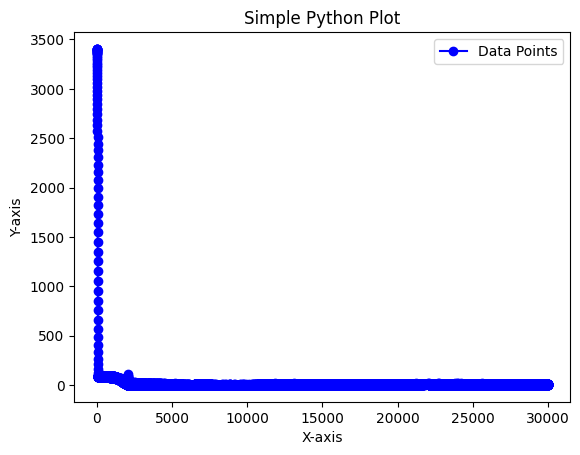

In [9]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(range(30000), loss_hist, marker='o', linestyle='-', color='b', label='Data Points')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Simple Python Plot')

# Show legend
ax.legend()

# Display the plot
plt.show()